In [1]:
from google.colab import files

uploaded = files.upload()

Saving stock_data.zip to stock_data.zip


In [2]:
!unzip stock_data.zip
!rm stock_data.zip

Archive:  stock_data.zip
   creating: stock_data/
  inflating: stock_data/A.jsonl      
  inflating: stock_data/AAN.jsonl    
  inflating: stock_data/AAOI.jsonl   
  inflating: stock_data/AAP.jsonl    
  inflating: stock_data/AAPL.jsonl   
  inflating: stock_data/AAWW.jsonl   
  inflating: stock_data/AB.jsonl     
  inflating: stock_data/ABB.jsonl    
  inflating: stock_data/ABBV.jsonl   
  inflating: stock_data/ABC.jsonl    
  inflating: stock_data/ABCB.jsonl   
  inflating: stock_data/ABDC.jsonl   
  inflating: stock_data/ABEV.jsonl   
  inflating: stock_data/ABG.jsonl    
  inflating: stock_data/ABIO.jsonl   
  inflating: stock_data/ABM.jsonl    
  inflating: stock_data/ABMD.jsonl   
  inflating: stock_data/ABR.jsonl    
  inflating: stock_data/ACAD.jsonl   
  inflating: stock_data/ACC.jsonl    
  inflating: stock_data/ACCO.jsonl   
  inflating: stock_data/ACET.jsonl   
  inflating: stock_data/ACGL.jsonl   
  inflating: stock_data/ACH.jsonl    
  inflating: stock_data/ACHC.jsonl   


In [2]:
# Prepare stock price history data
import json
import os

# Path to your folder containing .jsonl files
folder_path = 'stock_data/'

# Initialize an empty list to store the dictionaries from all files
stock_price_history_data_list = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(folder_path, filename)

        # Open and read each file
        with open(file_path, 'r') as file:
            for line in file:
                # Convert each line into a dictionary and append to the list
                stock_price_history_data_list.append(json.loads(line))

stock_price_history_data = {}

for entry in stock_price_history_data_list:
    if entry['stock'] not in stock_price_history_data:
        stock_price_history_data[entry['stock']] = {}
    stock_price_history_data[entry['stock']][entry['month_year']] = {
        'this_month_vw': entry['this_month_vw'],
        'next_month_vw': entry['next_month_vw'],
        'percentage_change': entry['percentage_change'],
    }

In [3]:
# Prepare training data
import json

# Path to your .jsonl file
file_path = 'cleaned_training_data.jsonl'

# Initialize an empty list to store the dictionaries
training_data_list = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        # Convert each line into a dictionary and append to the list
        training_data_list.append(json.loads(line))

training_data = {}

for entry in training_data_list:
    if entry['stock'] not in training_data:
        training_data[entry['stock']] = {}
    training_data[entry['stock']][entry['month_year']] = entry['data']

In [4]:
stock_price_history_data['A']['2019-02'], training_data['A']['2019-02']

({'this_month_vw': 77.448,
  'next_month_vw': 80.0518,
  'percentage_change': 0.03361997727507498},
 [{'title': 'Barclays Maintains Overweight on Agilent Technologies, Raises Price Target to $83',
   'date': '2019-02-21 08:00:00-05:00'},
  {'title': 'UPDATE: Agilent Raises FY19 Adj. EPS Guidance From $3-$3.05 To $3.03-$3.07 vs $3.05 Estimate, Sales From $5.13B-$5.17B To $5.15B-$5.19B vs $5.17B Est.',
   'date': '2019-02-20 16:07:00-05:00'},
  {'title': 'Agilent Sees Q2 Adj. EPS $0.70-$0.72 vs $0.72 Estimate, Sales $1.255B-$1.27B vs $1.27B Est.; Raises FY19 Guidance',
   'date': '2019-02-20 16:06:00-05:00'},
  {'title': 'Agilent Technologies Q1 EPS $0.76 Beats $0.73 Estimate, Sales $1.284B Beat $1.27B Estimate',
   'date': '2019-02-20 16:05:00-05:00'},
  {'title': '10 Stocks To Watch For February 20, 2019',
   'date': '2019-02-20 04:33:00-05:00'},
  {'title': 'Earnings Scheduled For February 20, 2019',
   'date': '2019-02-20 04:04:00-05:00'},
  {'title': 'JANA 13F Shows Liquidated Stake

### Top-k Retrival

In [6]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 70.1 MB/s eta 0:00:00


In [5]:
import faiss
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Lists to store processed data
presplit_texts = []
presplit_targets = []
presplit_vectors = []

# Initialize the vectorizer
vectorizer = TfidfVectorizer()
all_texts = []

# Collect all headlines for fitting the vectorizer
for ticker in stock_price_history_data.keys():
    for month_year in stock_price_history_data[ticker].keys():
        if month_year in training_data[ticker]:
            headlines = [item['title'] for item in training_data[ticker][month_year]]
            all_texts.extend(headlines)

# Fit vectorizer on the entire dataset
vectorizer.fit(all_texts)

# Process each ticker and time period
for ticker in stock_price_history_data.keys():
    for month_year in stock_price_history_data[ticker].keys():
        if month_year in training_data[ticker]:
            # Extract headlines and targets
            headlines = [item['title'] for item in training_data[ticker][month_year]]
            presplit_texts.append(headlines)
            presplit_targets.append(stock_price_history_data[ticker][month_year]['percentage_change'])

            # Use sparse matrix representation to save memory
            tfidf_matrix = vectorizer.transform(headlines)
            presplit_vectors.append(tfidf_matrix)

# Note: presplit_vectors will now contain sparse matrices.
# You can convert them to dense format only when needed, like this:
# dense_matrix = presplit_vectors[i].toarray()


In [9]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import faiss
import numpy as np

# Split the dataset into train and test sets
texts, test_texts, targets, test_targets, vectors, test_vectors = train_test_split(
    presplit_texts, presplit_targets, presplit_vectors, test_size=0.1, random_state=42
)

# Query vectorization
k = 5
query_text = ["latest stock prices news headlines"]
query_vector = vectorizer.transform(query_text).astype('float32')  # Keep it sparse for memory efficiency

top_k_texts = []

# Wrap the iteration over text groups with tqdm
for i, group_vectors in enumerate(tqdm(vectors)):
    # Convert the sparse matrix to a dense float32 array on demand
    dense_vectors = group_vectors.astype('float32').toarray()

    # Initialize FAISS index with the correct dimensionality
    dimension = dense_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)

    # Add vectors to the FAISS index
    index.add(dense_vectors)

    # Perform search for the top k matches
    D, I = index.search(query_vector.toarray(), k)  # Convert query vector to dense format for compatibility

    # Retrieve top k texts using indices
    selected_texts = [texts[i][selected_index] for selected_index in I[0]]
    top_k_texts.append(selected_texts)


100%|██████████| 15173/15173 [00:12<00:00, 1260.81it/s]


In [10]:
from tqdm import tqdm
import faiss
import numpy as np

test_top_k_texts = []

# Iterate over test vectors with tqdm for progress tracking
for i, group_vectors in enumerate(tqdm(test_vectors)):
    # Convert sparse test vectors to dense format on demand
    dense_group_vectors = group_vectors.astype('float32').toarray()

    # Initialize FAISS index with the appropriate dimensionality
    dimension = dense_group_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)

    # Add the dense group vectors to the FAISS index
    index.add(dense_group_vectors)

    # Perform the nearest-neighbor search
    D, I = index.search(query_vector.toarray(), k)  # Convert query vector to dense

    # Retrieve top k matching texts using indices
    selected_texts = [test_texts[i][selected_index] for selected_index in I[0]]
    test_top_k_texts.append(selected_texts)


100%|██████████| 1686/1686 [00:01<00:00, 1293.68it/s]


### Model Definition

In [11]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [13]:
class FinBERTRegressor(nn.Module):
    def __init__(self, finbert_model_name="ProsusAI/finbert", hidden_size=768, output_size=1):
        super(FinBERTRegressor, self).__init__()
        # Load the FinBERT model
        self.finbert = BertModel.from_pretrained(finbert_model_name)

        # Regression layer
        self.regressor = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Get embeddings from FinBERT
        with torch.no_grad():  # No need to calculate gradients for FinBERT
            outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)

        # We use the [CLS] token's embedding for regression
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Pass through the regression layer
        return self.regressor(cls_embedding)

In [14]:
model = FinBERTRegressor()
model.to(device)  # Move the model to the GPU

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

FinBERTRegressor(
  (finbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [15]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Dataset Processing

In [16]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm  # Import tqdm

# Assuming 'texts' is your list of texts to be tokenized
input_ids = []
attention_masks = []

# Wrap the iteration over texts with tqdm
for group_text in tqdm(top_k_texts, desc="Tokenizing"):
    text = ". ".join(group_text) + "."
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
targets = torch.tensor(targets)

# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, targets)

# DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

Tokenizing:   0%|          | 0/15173 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing:  12%|█▏        | 1811/15173 [00:03

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Tokenizing: 100%|██████████| 15173/15173 [00:34<00:00, 435.90it/s]


In [17]:
# Tokenize the test data
test_input_ids = []
test_attention_masks = []

for group_text in tqdm(test_top_k_texts, desc="Tokenizing Test Data"):
    text = ". ".join(group_text) + "."
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_targets = torch.tensor(test_targets)

# Create TensorDataset for test data
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_targets)

# Create DataLoader for test data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Tokenizing Test Data: 100%|██████████| 1686/1686 [00:04<00:00, 366.74it/s]


### Training Loop

In [18]:
avg_train_loss_history = []
avg_test_loss_history = []
# Initialize variables to track the best test loss and corresponding epoch
best_test_loss = float('inf')
best_epoch = 0

In [30]:
start_epoch = 1 # inclusive
end_epoch = 51 # exclusive

In [43]:
# Check if the model directory exists, if not, create it
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Training Loop
for epoch in range(start_epoch, end_epoch):
    # Training Phase
    model.train()
    total_train_loss = 0

    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}/{end_epoch - 1}')
    for batch in progress_bar:
        b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(b_input_ids, b_input_mask)
        loss = loss_fn(outputs.squeeze(), b_labels.float())
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch}/{end_epoch - 1} - Train Loss: {loss.item():.2f}")

    avg_train_loss = total_train_loss / len(dataloader)
    avg_train_loss_history.append(avg_train_loss)
    print(f'Epoch {epoch}/{end_epoch - 1} - Avg Train Loss: {avg_train_loss:.2f}')

    # Evaluation Phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
            outputs = model(b_input_ids, b_input_mask)
            loss = loss_fn(outputs.squeeze(), b_labels.float())
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss_history.append(avg_test_loss)
    print(f'Epoch {epoch}/{end_epoch - 1} - Avg Test Loss: {avg_test_loss:.2f}')

    # Keep track of the best epoch
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_epoch = epoch

    # Save the model weights
    model_save_path = os.path.join(model_dir, f'model_epoch_{epoch}.pth')
    torch.save(model.regressor.state_dict(), model_save_path)
    print(f'Model saved for epoch {epoch} at {model_save_path}')

Epoch 1/20 - Train Loss: 0.02: 100%|██████████| 949/949 [00:53<00:00, 17.85it/s]


Epoch 1/20 - Avg Train Loss: 0.23
Epoch 1/20 - Avg Test Loss: 0.04
Model saved for epoch 1 at model/model_epoch_1.pth


Epoch 2/20 - Train Loss: 0.08: 100%|██████████| 949/949 [00:50<00:00, 18.62it/s]


Epoch 2/20 - Avg Train Loss: 0.23
Epoch 2/20 - Avg Test Loss: 0.04
Model saved for epoch 2 at model/model_epoch_2.pth


Epoch 3/20 - Train Loss: 0.01: 100%|██████████| 949/949 [00:52<00:00, 18.24it/s]


Epoch 3/20 - Avg Train Loss: 0.22
Epoch 3/20 - Avg Test Loss: 0.04
Model saved for epoch 3 at model/model_epoch_3.pth


Epoch 4/20 - Train Loss: 0.05: 100%|██████████| 949/949 [00:52<00:00, 18.09it/s]


Epoch 4/20 - Avg Train Loss: 0.22
Epoch 4/20 - Avg Test Loss: 0.04
Model saved for epoch 4 at model/model_epoch_4.pth


Epoch 5/20 - Train Loss: 0.14: 100%|██████████| 949/949 [00:56<00:00, 16.88it/s]


Epoch 5/20 - Avg Train Loss: 0.22
Epoch 5/20 - Avg Test Loss: 0.04
Model saved for epoch 5 at model/model_epoch_5.pth


Epoch 6/20 - Train Loss: 0.01: 100%|██████████| 949/949 [00:52<00:00, 18.12it/s]


Epoch 6/20 - Avg Train Loss: 0.22
Epoch 6/20 - Avg Test Loss: 0.04
Model saved for epoch 6 at model/model_epoch_6.pth


Epoch 7/20 - Train Loss: 0.04: 100%|██████████| 949/949 [00:52<00:00, 18.01it/s]


Epoch 7/20 - Avg Train Loss: 0.22
Epoch 7/20 - Avg Test Loss: 0.04
Model saved for epoch 7 at model/model_epoch_7.pth


Epoch 8/20 - Train Loss: 0.14: 100%|██████████| 949/949 [00:53<00:00, 17.86it/s]


Epoch 8/20 - Avg Train Loss: 0.22
Epoch 8/20 - Avg Test Loss: 0.03
Model saved for epoch 8 at model/model_epoch_8.pth


Epoch 9/20 - Train Loss: 0.01: 100%|██████████| 949/949 [00:52<00:00, 18.15it/s]


Epoch 9/20 - Avg Train Loss: 0.22
Epoch 9/20 - Avg Test Loss: 0.03
Model saved for epoch 9 at model/model_epoch_9.pth


Epoch 10/20 - Train Loss: 0.01: 100%|██████████| 949/949 [00:52<00:00, 18.08it/s]


Epoch 10/20 - Avg Train Loss: 0.22
Epoch 10/20 - Avg Test Loss: 0.03
Model saved for epoch 10 at model/model_epoch_10.pth


Epoch 11/20 - Train Loss: 0.05: 100%|██████████| 949/949 [00:52<00:00, 18.13it/s]


Epoch 11/20 - Avg Train Loss: 0.22
Epoch 11/20 - Avg Test Loss: 0.03
Model saved for epoch 11 at model/model_epoch_11.pth


Epoch 12/20 - Train Loss: 0.06: 100%|██████████| 949/949 [00:52<00:00, 18.10it/s]


Epoch 12/20 - Avg Train Loss: 0.22
Epoch 12/20 - Avg Test Loss: 0.03
Model saved for epoch 12 at model/model_epoch_12.pth


Epoch 13/20 - Train Loss: 0.01: 100%|██████████| 949/949 [00:52<00:00, 18.06it/s]


Epoch 13/20 - Avg Train Loss: 0.22
Epoch 13/20 - Avg Test Loss: 0.03
Model saved for epoch 13 at model/model_epoch_13.pth


Epoch 14/20 - Train Loss: 0.07: 100%|██████████| 949/949 [00:52<00:00, 18.11it/s]


Epoch 14/20 - Avg Train Loss: 0.22
Epoch 14/20 - Avg Test Loss: 0.03
Model saved for epoch 14 at model/model_epoch_14.pth


Epoch 15/20 - Train Loss: 0.03: 100%|██████████| 949/949 [00:52<00:00, 18.14it/s]


Epoch 15/20 - Avg Train Loss: 0.22
Epoch 15/20 - Avg Test Loss: 0.03
Model saved for epoch 15 at model/model_epoch_15.pth


Epoch 16/20 - Train Loss: 0.08: 100%|██████████| 949/949 [00:52<00:00, 18.10it/s]


Epoch 16/20 - Avg Train Loss: 0.22
Epoch 16/20 - Avg Test Loss: 0.03
Model saved for epoch 16 at model/model_epoch_16.pth


Epoch 17/20 - Train Loss: 0.00: 100%|██████████| 949/949 [00:52<00:00, 18.13it/s]


Epoch 17/20 - Avg Train Loss: 0.22
Epoch 17/20 - Avg Test Loss: 0.03
Model saved for epoch 17 at model/model_epoch_17.pth


Epoch 18/20 - Train Loss: 0.04: 100%|██████████| 949/949 [00:52<00:00, 18.11it/s]


Epoch 18/20 - Avg Train Loss: 0.22
Epoch 18/20 - Avg Test Loss: 0.04
Model saved for epoch 18 at model/model_epoch_18.pth


Epoch 19/20 - Train Loss: 0.02: 100%|██████████| 949/949 [00:52<00:00, 18.14it/s]


Epoch 19/20 - Avg Train Loss: 0.22
Epoch 19/20 - Avg Test Loss: 0.03
Model saved for epoch 19 at model/model_epoch_19.pth


Epoch 20/20 - Train Loss: 0.01: 100%|██████████| 949/949 [00:52<00:00, 18.12it/s]


Epoch 20/20 - Avg Train Loss: 0.22
Epoch 20/20 - Avg Test Loss: 0.03
Model saved for epoch 20 at model/model_epoch_20.pth


### Training Statistics

In [42]:
rmse = mean_squared_error(test_targets, all_predictions, squared=False)
print(f"RMSE: {rmse:.2f}")

RMSE: 0.19


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
# Print the best epoch and its test loss after all epochs are completed
print(f'Best epoch: {best_epoch} with Test Loss: {best_test_loss:.2f}')

Best epoch: 16 with Test Loss: 0.04


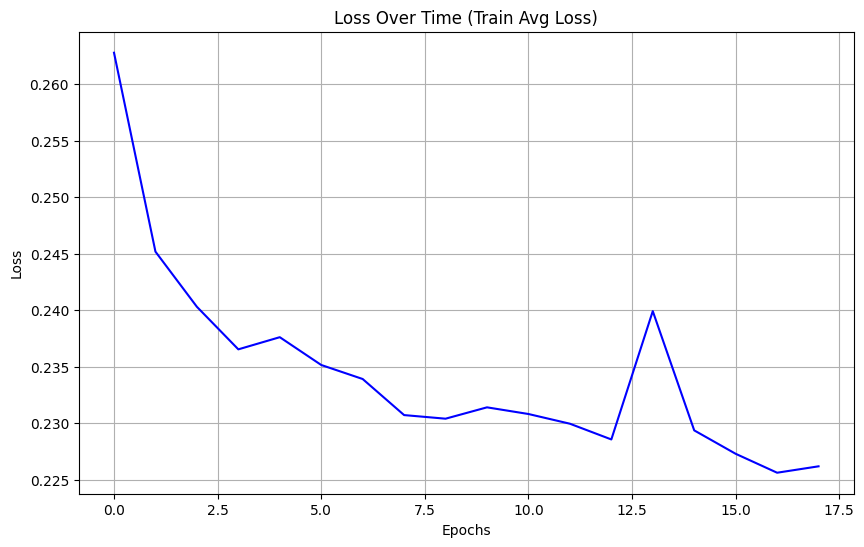

In [24]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(avg_train_loss_history, linestyle='-', color='b')  # Line plot without markers

# Adding title and labels
plt.title('Loss Over Time (Train Avg Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optionally, add a grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

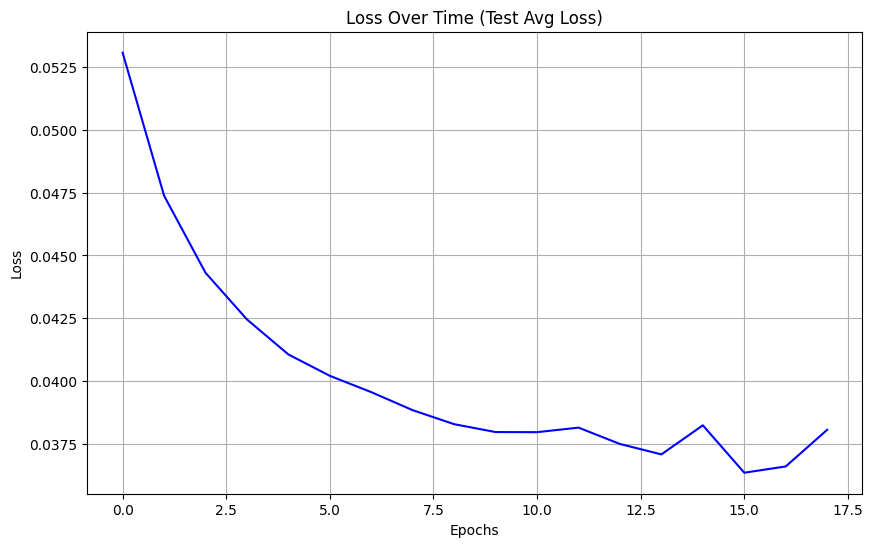

In [25]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(avg_test_loss_history, linestyle='-', color='b')  # Line plot without markers

# Adding title and labels
plt.title('Loss Over Time (Test Avg Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optionally, add a grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

### Model Information

In [26]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.regressor.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 769


In [27]:
!ls -lh model/model_epoch_1.pth

-rw-r--r-- 1 root root 4.5K Nov 15 17:56 model/model_epoch_1.pth


### Downloading Model Data

In [28]:
import json
from google.colab import files

# Example dictionary
data = {
    'batch_size': batch_size,
    'learning_rate': 1e-5,
    'num_epochs': 50,
    'best_epoch': best_epoch,
    'best_test_loss': best_test_loss,
    'avg_train_loss_history': avg_train_loss_history,
    'avg_test_loss_history': avg_test_loss_history,
}

# Convert dictionary to JSON formatted string
json_data = json.dumps(data, indent=4)

# Write JSON data to a file
filename = 'model_training_data_v2.json'
with open(filename, 'w') as file:
    file.write(json_data)

# Download the file to your local system
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Download the best model weight to your local system
files.download(f'model/model_epoch_{best_epoch}.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Examples Inputs & Outputs

In [32]:
# Assuming 'model' is your PyTorch model and 'tokenizer' is your tokenizer
text = "Google stock crashs and the company files for backruptcy"

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move the inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Generate output
output = model(**inputs)

print(f"Prediction is {abs(output.item()) * 100:.2f}% {'rise' if output.item() > 0 else 'fall'} in the stock price during next month.")

Prediction is 5.23% fall in the stock price during next month.
